In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# tạo hàm convert gray
def convert_to_grayscale(image):
    # Convert the color image to grayscale using OpenCV
    grayscale_image = image.copy()
    if len(image.shape) > 2:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayscale_image

In [3]:
#tạo hàm đọc ảnh, trả ra image và template
def read_image_template(image_name, template_name):
    image = cv2.imread(image_name)
    template = cv2.imread(template_name)

    return image, template

In [4]:
def scale_image(image, ratio):
    h, w = image.shape[:2]
    new_image = cv2.resize(image, (int(w*ratio), int(h*ratio)), interpolation=cv2.INTER_AREA if ratio < 1 else cv2.INTER_LINEAR)
    return new_image

In [5]:
def show_image(image):
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis('off')
    plt.imshow(new_image)

In [6]:
import cv2
import numpy as np

def rotate_image(image, angle):
    """
    Xoay ảnh một góc nhất định và mở rộng kích thước để bao hàm toàn bộ ảnh sau khi xoay
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Ma trận xoay ban đầu
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Tính toán kích thước mới của khung hình sau khi xoay
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # Kích thước mới của khung hình
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Điều chỉnh ma trận xoay để dịch ảnh vào giữa khung hình mới
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # Thực hiện phép biến đổi affine với kích thước mới
    rotated = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated


In [7]:
def compare_size_2image(image1, image2):
    h1, w1 = image1.shape
    h2, w2 = image2.shape
    if h1 <= h2 and w1 <= w2:
        return 0
    elif h1 > h2 and w1 > w2:
        return 1
    else:
        return 2

In [8]:
def non_max_suppression_slow(boxes, scores, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(scores)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
		# loop over all indexes in the indexes list
		for pos in np.arange(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick], scores[pick]

In [9]:
def detection(originalimage, image, template, threshold):
    # image_gray = convert_to_grayscale(image)
    # template_gray = convert_to_grayscale(template)

    detected_image = np.copy(originalimage)
    
    overlapThresh = 0.2
    
    best_detections = []
    scores = []

    for r in np.linspace(0.5,2,31):
        scale_template = scale_image(template, r)
        for flip_number in [-1,0,1]:
            new_template = cv2.flip(scale_template, flip_number)
            # new_template_gray = scale_template_gray
            cs2i = compare_size_2image(new_template, image)
            if cs2i == 0:
                corr = cv2.matchTemplate(image, new_template, method=cv2.TM_CCOEFF_NORMED)

                indces = list(zip(*np.where(corr > threshold)))

                for loc in indces:
                    # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

                    h, w = new_template.shape[:2]
                    top_left = loc[1], loc[0]
                    bottom_right = (top_left[0] + w, top_left[1] + h)

                    # cv2.rectangle(detected_image, top_left, bottom_right, (0, 255, 0), 2)

                    # if max_val > threshold:
                    best_detections.append((*top_left, *bottom_right))
                    scores.append(corr[loc])
        # print(r)

    best_detections = np.array(best_detections)
    scores = np.array(scores)
    # print(best_detections, scores)
    pos_detections, pos_scores = [], []
    if len(best_detections) > 0:

        pos_detections, pos_scores = non_max_suppression_slow(best_detections, scores, overlapThresh)
    # Vẽ hình chữ nhật quanh vị trí tìm thấy mẫu
    # print(pos_detections, pos_scores)
    count = 0
    for x1, y1, x2, y2 in pos_detections:

        top_left = x1, y1
        bottom_right = x2, y2
        cv2.rectangle(detected_image, top_left, bottom_right, (0, 0, 255), 2)

        count += 1
        # font = cv2.FONT_HERSHEY_SIMPLEX
        # text_position = (top_left[0], top_left[1] - 10)  # Hiển thị số đếm phía trên hình chữ nhật
        # cv2.putText(detected_image, str(count), text_position, font, 1, (0, 255, 0), 2)
        
    return detected_image, count

In [10]:
def counting(image_name, template_name, threshold):
    image, template = read_image_template(image_name, template_name)
    originalimage = image.copy()

    image = convert_to_grayscale(image)
    template = convert_to_grayscale(template)
    image = cv2.Canny(image, 50, 150)
    template = cv2.Canny(template, 50, 150)


    detec, count = detection(originalimage, image, template, threshold)
    show_image(detec)
    print(f"Số lượng đếm trong hình: {count}")

In [11]:

def counting_using_histogram(image_name, template_name, threshold):
    # Đường dẫn tới file ảnh chính và template mẫu chuột
    image_path = image_name
    template_path = template_name  # Bạn cần chuẩn bị ảnh mẫu chuột riêng

    # Đọc ảnh chính và ảnh mẫu chuột
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)

    # Chuyển đổi ảnh chính và ảnh mẫu sang không gian màu RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

    # Tính toán histogram cho template chuột (mẫu)
    template_histograms = []
    for i in range(3):
        template_hist = cv2.calcHist([template_rgb], [i], None, [256], [0, 256])
        template_histograms.append(cv2.normalize(template_hist, template_hist).flatten())

    # Chia nhỏ hình ảnh chính thành các ô nhỏ để so sánh
    height, width, _ = image_rgb.shape
    grid_size = 50  # Kích thước mỗi ô là 50x50
    mouse_count = 0

    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            # Cắt một phần của ảnh chính với kích thước bằng kích thước của template
            roi = image_rgb[y:y + grid_size, x:x + grid_size]

            # Tính toán histogram cho phần ảnh đó
            roi_histograms = []
            for i in range(3):
                roi_hist = cv2.calcHist([roi], [i], None, [256], [0, 256])
                roi_histograms.append(cv2.normalize(roi_hist, roi_hist).flatten())

            # So sánh histogram của phần ảnh đó với histogram của template
            similarity = 0
            for roi_hist, template_hist in zip(roi_histograms, template_histograms):
                similarity += cv2.compareHist(roi_hist, template_hist, cv2.HISTCMP_CORREL)

            # Nếu độ tương đồng vượt quá ngưỡng, đếm là một chuột
            if similarity / 3 > threshold:  # Ngưỡng tương đồng 0.7
                mouse_count += 1
                cv2.rectangle(image, (x, y), (x + grid_size, y + grid_size), (0, 255, 0), 2)

    # Hiển thị ảnh với số lượng chuột đếm được
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Số lượng đếm được: {mouse_count}")
    plt.axis('off')
    plt.show()

    # In ra số lượng chuột đếm được
    # print(f"Số lượng đếm được: {mouse_count}")


Số lượng đếm trong hình: 198


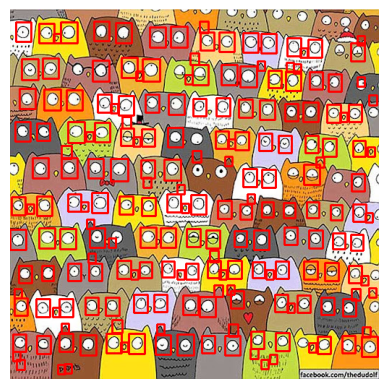

In [12]:
image_name = "cat/image.png"
template_name = "cat/template2.png"

counting(image_name, template_name, 0.4)
# counting_using_histogram(image_name, template_name, 0.5)

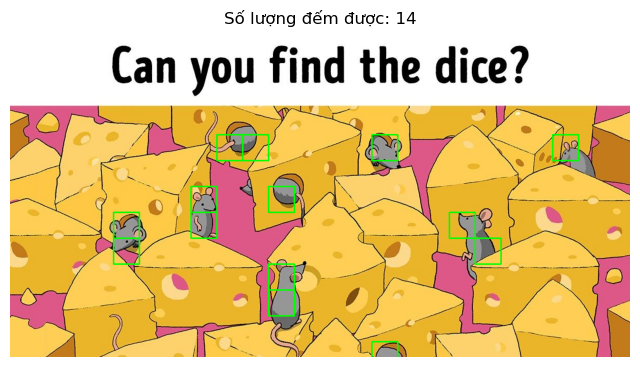

In [18]:
image_name = "mouse/image.png"
template_name = "mouse/template.png"

# counting(image_name, template_name, 0.6)
counting_using_histogram(image_name, template_name, 0.4)

Số lượng đếm trong hình: 36


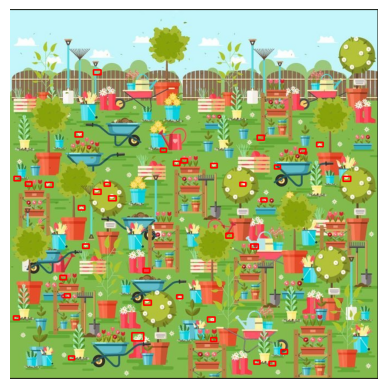

In [14]:
image_name = "pair_boot/image.png"
template_name = "pair_boot/template2.png"

counting(image_name, template_name, 0.5)
# counting_using_histogram(image_name, template_name, 0.8)

Số lượng đếm trong hình: 16


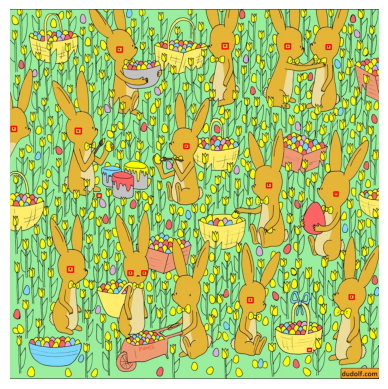

In [15]:
image_name = "rabbit/image.png"
template_name = "rabbit/template2.png"

counting(image_name, template_name, 0.8)
# counting_using_histogram(image_name, template_name, 0.6)

Số lượng đếm trong hình: 47


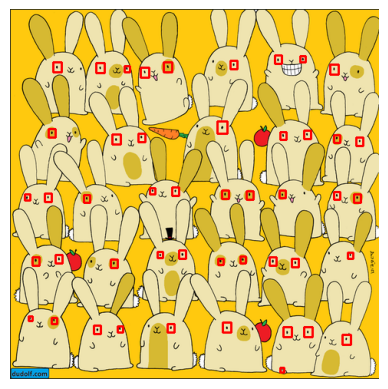

In [16]:
image_name = "rabbit2/image.png"
template_name = "rabbit2/template2.png"

counting(image_name, template_name, 0.7)
# counting_using_histogram(image_name, template_name, 0.4)